In [22]:
import gym
import torch
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
class Actor(nn.Module):
  def __init__(self,input_size:int=4,hidden_size:int=16,output_size:int=2):
    super().__init__()
    self.fc1 = nn.Linear(input_size,hidden_size)
    self.fc2 = nn.Linear(hidden_size,output_size)

  def forward(self,s):
    outs = self.fc1(s)
    outs = F.relu(outs)
    logits = self.fc2(outs)
    return logits



In [24]:
class Critic(nn.Module):
  def __init__(self,input_size:int=4,hidden_size:int=16,output_size:int=1):
    super().__init__()
    self.fc1 = nn.Linear(input_size,hidden_size)
    self.fc2 = nn.Linear(hidden_size,output_size)

  def forward(self,s):
    outs = self.fc1(s)
    outs = F.relu(outs)
    value = self.fc2(outs)
    return value


In [25]:
class PPO:
  def __init__(self,
               actor,
               critic,
               gamma:float=0.99,
               kl_coeff:float=0.2,
               critic_coeff:float=0.5,
               env_name :str="CartPole-v1"):
    self.actor = actor
    self.critic = critic
    self.gamma = gamma
    self.kl_coeff = kl_coeff
    self.critic_coeff = critic_coeff
    self.env = gym.make(env_name)
    self.reward_records = []
    parameters = list(self.actor.parameters()) + list(self.critic.parameters())
    self.opt = torch.optim.AdamW(parameters,lr=0.0005)

  def sample(self,s):
    with torch.no_grad():
      s_batch = np.expand_dims(s,axis=0)
      s_batch = torch.tensor(s_batch,dtype=torch.float).to(device)
      logits = self.actor(s_batch)
      logits = logits.squeeze(dim=0)
      probs = F.softmax(logits,dim=-1)
      a = torch.multinomial(probs,num_samples=1)
      a = a.squeeze(dim=0)
      logprob = -F.cross_entropy(logits,a,reduction='none')
      return a.tolist(),logits.tolist(),logprob.tolist()

  def train(self):
    for i in range(5000):
      done = False
      states = []
      actions = []
      rewards = []
      logits = []
      logprbs = []
      s = self.env.reset()
      while not done:
        states.append(s)
        a,l,p = self.sample(s.tolist())
        s,r,term,trunc = self.env.step(a)
        done = term or trunc
        actions.append(a)
        logits.append(l)
        logprbs.append(p)
        rewards.append(r)

      cum_rewards = np.zeros_like(rewards)
      reward_len = len(rewards)
      for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*self.gamma if j+1 < reward_len else 0)

      self.opt.zero_grad()
      states = torch.tensor(states,dtype=torch.float).to(device)
      actions = torch.tensor(actions,dtype=torch.int64).to(device)
      logits_old = torch.tensor(logits,dtype=torch.float).to(device)
      logprbs = torch.tensor(logprbs,dtype=torch.float).to(device)
      logprbs = logprbs.unsqueeze(dim=1)
      cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
      cum_rewards = cum_rewards.unsqueeze(dim=1)

      # Get values and logits with new parameters
      values_new = self.critic(states)
      logits_new = self.actor(states)

      # Get advantages
      advantages = cum_rewards - values_new

      # Calculate P_new / P_old
      logprbs_new = -F.cross_entropy(logits_new, actions, reduction="none")
      logprbs_new = logprbs_new.unsqueeze(dim=1)
      prob_ratio = torch.exp(logprbs_new - logprbs)

      # Calculate KL-div for Categorical distribution (see above)
      l0 = logits_old - torch.amax(logits_old, dim=1, keepdim=True) # reduce quantity ,for stability issue
      l1 = logits_new - torch.amax(logits_new, dim=1, keepdim=True) # reduce quantity
      e0 = torch.exp(l0)
      e1 = torch.exp(l1)
      e_sum0 = torch.sum(e0, dim=1, keepdim=True)
      e_sum1 = torch.sum(e1, dim=1, keepdim=True)
      p0 = e0 / e_sum0

      kl = torch.sum(p0 * (l0 - torch.log(e_sum0) - l1 + torch.log(e_sum1)),dim=1,keepdim=True)
      # Get value loss
      critic_loss = F.mse_loss(values_new,cum_rewards,reduction="none")
      # Get total loss
      loss = -advantages * prob_ratio + kl * self.kl_coeff + critic_loss * self.critic_coeff
      # Optimize
      loss.sum().backward()
      self.opt.step()

      # Output total rewards in episode (max 500)
      print("Run episode{} with rewards {}".format(i, np.sum(rewards)))
      self.reward_records.append(np.sum(rewards))

      # stop if reward mean > 475.0
      if np.average(self.reward_records[-50:]) > 475.0:
        break

    print('\nDone')
    self.env.close()

  def plot(self):
    import matplotlib.pyplot as plt
    # Generate recent 50 interval average
    average_reward = []
    for idx in range(len(self.reward_records)):
      avg_list = np.empty(shape=(1,), dtype=int)
      if idx < 50:
          avg_list = self.reward_records[:idx+1]
      else:
          avg_list = self.reward_records[idx-49:idx+1]
      average_reward.append(np.average(avg_list))
    plt.plot(self.reward_records)
    plt.plot(average_reward)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Run episode0 with rewards 16.0
Run episode1 with rewards 13.0
Run episode2 with rewards 17.0
Run episode3 with rewards 10.0
Run episode4 with rewards 25.0
Run episode5 with rewards 10.0
Run episode6 with rewards 22.0
Run episode7 with rewards 43.0
Run episode8 with rewards 11.0
Run episode9 with rewards 10.0
Run episode10 with rewards 33.0
Run episode11 with rewards 12.0
Run episode12 with rewards 11.0
Run episode13 with rewards 11.0
Run episode14 with rewards 21.0
Run episode15 with rewards 17.0
Run episode16 with rewards 17.0
Run episode17 with rewards 15.0
Run episode18 with rewards 12.0
Run episode19 with rewards 17.0
Run episode20 with rewards 17.0
Run episode21 with rewards 23.0
Run episode22 with rewards 15.0
Run episode23 with rewards 57.0
Run episode24 with rewards 14.0
Run episode25 with rewards 39.0
Run episode26 with rewards 12.0
Run episode27 with rewards 19.0
Run episode28 with rewards 27.0
Run episode29 with rewards 17.0
Run episode30 with rewards 41.0
Run episode31 with

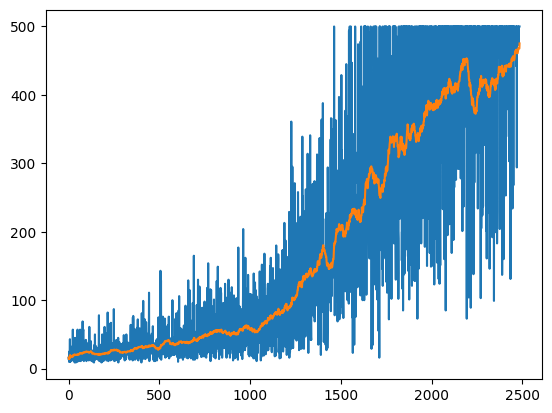

In [26]:
actor = Actor().to(device)
critic = Critic().to(device)
agent = PPO(actor,critic)
agent.train()
agent.plot()